In [1]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots
sns.set()
import warnings  
warnings.filterwarnings('ignore')
from itertools import product  # some useful functions
import scipy.stats as scs
from dateutil.relativedelta import relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from sklearn.model_selection import TimeSeriesSplit  # you have everything done for you 
from sklearn.model_selection import train_test_split
import datetime
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import regularizers

In [2]:
df_G2 = pd.read_csv('G2.csv.xls', sep = ',') 
df_G2['date'] = df_G2['date'].map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
# print(df_G2)
print(df_G2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    156 non-null    datetime64[ns]
 1   SO2op1  156 non-null    float64       
 2   SO2op2  156 non-null    float64       
 3   T       156 non-null    float64       
 4   SO2     156 non-null    float64       
 5   NO2     156 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 7.4 KB
None


Предварительная подготовка данных, разделение тестового набора G2 на обучающую и валидационную выборку. На которой в дальнейшем будет анализироваться результаты моделей и проводиться сравнение. Обращаю внимание что размеченная валидационная выборка не участвует в обучении моделей. Для настройки гиперпараметров на обучающей выборке используется кросс-валидация(мало данных).

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


y = df_G2.dropna()['SO2']
X = df_G2.dropna().drop(['SO2'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33)

time_train = X_train.dropna()['date']
X_train = X_train.drop(['date'], axis=1)
time_valid = X_valid.dropna()['date']
X_valid = X_valid.drop(['date'], axis=1)


X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid))
list_X = X_train.columns.values.tolist()
X_train_scaled.set_axis(list_X, axis = 'columns', inplace=True)
X_valid_scaled.set_axis(list_X, axis = 'columns', inplace=True)


# print(X_train_scaled)

Масштабирование тренировочных данных - необязательно для нейронной сети.
Для моделей MLR обязательно при условии сравнения коэффициентов.

В качестве Loss функции потерь для нн был выбран MAE. 
Ранее в работах показывал превосходство над минимизацией MSE.

In [32]:
from keras import models
from keras import layers
from sklearn.datasets import make_regression
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold
kfold = RepeatedKFold(n_splits=5, n_repeats=4)

# Type_error = 'mape'

List_Error = ['mean_absolute_percentage_error', 'mean_squared_error']
Type_error = 'mean_squared_error'



from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dropout

l_feat = X_train_scaled.shape[1]
loss_func = 'mean_absolute_error'





def network_model(l_r = 0.01, d_c = 0.001, reg = -1, activ = 'tanh',\
                  n_layer = 1, n_neur = 3, drop = 0):
    network = models.Sequential()
    for j in range(n_layer):
        network.add(layers.Dense(units = n_neur, activation = activ, input_shape=(l_feat,),\
                                 kernel_regularizer=regularizers.L1(10**reg)))
        network.add(Dropout(drop))
    network.add(layers.Dense(units = 1, activation = 'linear'))
    network.compile(loss = loss_func, optimizer = \
                    keras.optimizers.Adam(learning_rate = l_r, decay = d_c),\
                    metrics='mean_absolute_percentage_error') 
    return network

Настройка гиперпараметров по поиску по сетке. Удачнее было бы использовать $\bf optuna$. Модели простые, с малым количеством тестовых данных, поэтому поиск по сетке тоже даёт приемлемые результаты.
Алгоритм ADAM, с затуханием decay, для сползания в локальный минимум. Функции активации стандартные, relu и tanh.
Ранее гиперболический тангенс показывал достойные результаты на полевой калибровке. Но здесь оказалась удачнее relu.

In [ ]:
FFNN = KerasRegressor(build_fn = network_model, verbose=0)



parameters = {
                'l_r': [0.001,0.01, 0.1],
                'd_c': [0.001, 0.01,0.1],
                'reg': [-1, -1.5,-2],
                'n_layer': [1,2,3],
                'n_neur': [2,3,4,5],
                'activ': ['tanh','relu'],
                'drop': [0, 0.2, 0.4],
                'batch_size': [4,8,16],
              # 'activ': ['linear', 'tanh', 'sigmoid', 'relu', 'exponential']
                'epochs': [10,50]
                }
#                            scoring='neg_mean_squared_error',
#                            scoring = "neg_mean_absolute_percentage_error",
grid =  GridSearchCV(estimator = FFNN, param_grid = parameters,\
                     scoring = "neg_mean_absolute_error", cv = 5,\
                     n_jobs = -1)




# grid_result = grid.fit(X_train_scaled, y_train)


# print(grid_result.best_params_)
# print(grid_result.best_score_)


# # print(grid_result.cv_results_)

# df_result = pd.DataFrame(grid_result.cv_results_)
# print(df_result)

# df_result.to_csv("GSCV/GSCV_1.csv", index=True)




In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print()
print("GSCV 1")
df_gscv = pd.read_csv('GSCV/GSCV_1.csv') 

list_column = ['param_l_r', 'param_d_c', 'param_reg',\
               'param_n_layer', 'param_n_neur','param_activ',\
               'param_drop', 'param_batch_size', 'param_epochs',\
               'mean_test_score','std_test_score','rank_test_score']
df_gscv = df_gscv[list_column]
df_gscv.sort_values(by='rank_test_score', inplace = True)
print(df_gscv.head(10))
print(df_gscv.tail(10))



GSCV 1
       param_l_r  param_d_c  param_reg  param_n_layer  param_n_neur  \
9923         0.1      0.001       -2.0              2             5   
6029         0.1      0.001       -2.0              2             3   
7976         0.1      0.001       -2.0              2             4   
6035         0.1      0.001       -2.0              2             5   
6019         0.1      0.001       -1.5              1             4   
6023         0.1      0.001       -2.0              1             5   
10568        0.1      0.010       -2.0              2             4   
6017         0.1      0.001       -2.0              1             3   
7975         0.1      0.001       -1.5              2             4   
6013         0.1      0.001       -1.5              1             2   

      param_activ  param_drop  param_batch_size  param_epochs  \
9923         relu         0.0                16            50   
6029         relu         0.0                 4            50   
7976         re

Фиксируем лучшие гиперпараметры и уточняем оставшиеся.  

In [7]:
FFNN = KerasRegressor(build_fn = network_model, verbose=0)

parameters = {
                'l_r': [0.03,0.1,0.3],
                'd_c': [0.0003,0.001,0.003],
                'reg': [-2,-3,-4],
                'n_layer': [2,3],
                'n_neur': [3,4,5],
                'activ': ['relu'],
#                 'drop': [0],
                'batch_size': [4,8,16],
              # 'activ': ['linear', 'tanh', 'sigmoid', 'relu', 'exponential']
                'epochs': [50,100,200]
                }
#                            scoring='neg_mean_squared_error',
#                            scoring = "neg_mean_absolute_percentage_error",
grid =  GridSearchCV(estimator = FFNN, param_grid = parameters,\
                     scoring = "neg_mean_absolute_error", cv = 5,\
                     n_jobs = -1)




# grid_result = grid.fit(X_train_scaled, y_train)


# print(grid_result.best_params_)
# print(grid_result.best_score_)


# # print(grid_result.cv_results_)

# df_result = pd.DataFrame(grid_result.cv_results_)
# print(df_result)

# df_result.to_csv("GSCV/GSCV_2.csv", index=True)





In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print()
print("GSCV 2")
df_gscv = pd.read_csv('GSCV/GSCV_2.csv') 

list_column = ['param_l_r', 'param_d_c', 'param_reg',\
               'param_n_layer', 'param_n_neur','param_activ',\
               'param_batch_size', 'param_epochs',\
               'mean_test_score','std_test_score','rank_test_score']
df_gscv = df_gscv[list_column]
df_gscv.sort_values(by='rank_test_score', inplace = True)
print(df_gscv.head(10))
print(df_gscv.tail(10))


GSCV 2
      param_l_r  param_d_c  param_reg  param_n_layer  param_n_neur  \
445        0.03      0.003         -3              3             4   
440        0.03      0.003         -4              2             5   
278        0.03      0.001         -4              2             5   
772        0.03      0.001         -3              3             5   
1429       0.10      0.003         -3              2             5   
458        0.10      0.003         -4              2             5   
933        0.03      0.003         -2              3             5   
763        0.03      0.001         -3              2             5   
942        0.10      0.003         -2              2             5   
287        0.03      0.001         -4              3             5   

     param_activ  param_batch_size  param_epochs  mean_test_score  \
445         relu                 4           200        -1.292600   
440         relu                 4           200        -1.346131   
278         re

Двух скрытых слоёв оказалось достаточно. Уточняем параметр регуляризации в скрытом слое.

In [9]:
FFNN = KerasRegressor(build_fn = network_model, verbose=0)

parameters = {
                'l_r': [0.01,0.03,0.1],
                'd_c': [0.0001,0.0003,0.001],
                'reg': [-3,-3.5,-4],
                'n_layer': [2],
                'n_neur': [4,5],
                'activ': ['relu'],
#                 'drop': [0],
                'batch_size': [4,8],
              # 'activ': ['linear', 'tanh', 'sigmoid', 'relu', 'exponential']
                'epochs': [200,400]
                }
#                            scoring='neg_mean_squared_error',
#                            scoring = "neg_mean_absolute_percentage_error",
grid =  GridSearchCV(estimator = FFNN, param_grid = parameters,\
                     scoring = "neg_mean_absolute_error", cv = 5,\
                     n_jobs = -1)




# grid_result = grid.fit(X_train_scaled, y_train)


# print(grid_result.best_params_)
# print(grid_result.best_score_)


# # print(grid_result.cv_results_)

# df_result = pd.DataFrame(grid_result.cv_results_)
# print(df_result)

# df_result.to_csv("GSCV/GSCV_3.csv", index=True)






In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print()
print("GSCV 3")
df_gscv = pd.read_csv('GSCV/GSCV_3.csv') 

list_column = ['param_l_r', 'param_d_c', 'param_reg',\
               'param_n_neur','param_activ',\
               'param_batch_size', 'param_epochs',\
               'mean_test_score','std_test_score','rank_test_score']
df_gscv = df_gscv[list_column]
df_gscv.sort_values(by='rank_test_score', inplace = True)
print(df_gscv.head(10))
print(df_gscv.tail(10))


GSCV 3
     param_l_r  param_d_c  param_reg  param_n_neur param_activ  \
167       0.01     0.0003       -4.0             5        relu   
99        0.03     0.0010       -3.0             5        relu   
59        0.01     0.0003       -4.0             5        relu   
105       0.10     0.0010       -3.0             5        relu   
55        0.01     0.0003       -3.5             4        relu   
173       0.03     0.0003       -4.0             5        relu   
100       0.03     0.0010       -3.5             5        relu   
205       0.03     0.0010       -3.5             4        relu   
126       0.01     0.0001       -3.0             4        relu   
215       0.10     0.0010       -4.0             5        relu   

     param_batch_size  param_epochs  mean_test_score  std_test_score  \
167                 8           400        -1.241257        0.369352   
99                  4           400        -1.264703        0.181871   
59                  4           400        -1.289

Построим кривую тренировки, Зависимость ошибок на метриках MAE, MSE от Epochs

In [11]:
min_epoch = 0

def plot_loss(history, string_l = 'Loss', draw_val = False):
    
#     plt.figure(figsize = (16,10))
#     plt.plot(history.history['loss'], label='Train')
#     if draw_val:
#         plt.plot(history.history['val_loss'], label='Valid')
#     plt.title(string_l)
#     plt.xlabel('Epochs')
#     plt.ylabel('Error')   
#     plt.legend()
#     plt.grid(True)

    figure, axis = plt.subplots(1,2) 
    axis[0].plot(history.history['mean_squared_error'][min_epoch:], label="Train", linewidth=1.5, color = "red")
    axis[0].plot(history.history['val_mean_squared_error'][min_epoch:], label="Validation", linewidth=1.5, color = "green")
    axis[0].set_title("MSE")
    axis[0].set_xlabel('Epochs')
    axis[0].set_ylabel('MSE')
    axis[0].set_ylim(0,25)
    axis[0].legend(loc="best")

    axis[1].plot(history.history['mean_absolute_error'][min_epoch:], label="Train", linewidth=1.5, color = "red")
    axis[1].plot(history.history['val_mean_absolute_error'][min_epoch:], label="Validation", linewidth=1.5, color = "green")
    axis[1].set_title("MAE")
    axis[1].set_xlabel('Epochs')
    axis[1].set_ylabel('MAE')
    axis[1].set_ylim(0,3)
    axis[1].legend(loc="best")


In [12]:
ffnn = models.Sequential()

ffnn.add(layers.Dense(units = 5, activation = 'relu', input_shape=(l_feat,),\
                      kernel_regularizer=regularizers.L1(10**(-4))))
ffnn.add(layers.Dense(units = 5, activation = 'relu',\
                      kernel_regularizer=regularizers.L1(10**(-4))))
ffnn.add(layers.Dense(units = 1, activation = 'linear'))
ffnn.compile(loss = 'mean_absolute_error', optimizer = \
             keras.optimizers.Adam(learning_rate = 0.01, decay = 0.001),\
             metrics=['mean_absolute_error','mean_squared_error']) 
history = ffnn.fit(X_train_scaled, y_train, verbose=0, epochs = 4000,\
                   batch_size = 4, validation_data = (X_valid_scaled,y_valid))

2022-11-15 22:12:14.790218: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 22:12:15.208313: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])


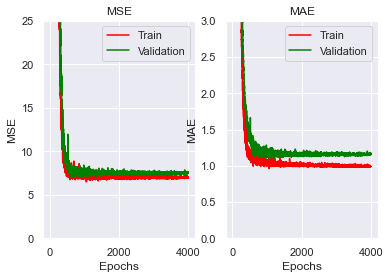

In [13]:
print(history)
plot_loss(history, string_l = "FFNN", draw_val = True)
print(history.history.keys())

Как видно из графиков ошибка на валидации достаточно близка к ошибки на тесте. Это говорит о хорошей сложности модели. Увеличение слоёв приведёт к переобучению. Уменьшение слоёв к недообучению.

Достаточное количество эпох - 500, лучше 1000.
Можно обойтись и меньшим но для этого надо увеличивать параметр распада для скорости обучения, при этом можем не дойти до минимума.

In [16]:
ffnn = models.Sequential()

ffnn.add(layers.Dense(units = 5, activation = 'relu', input_shape=(l_feat,),\
                      kernel_regularizer=regularizers.L1(10**(-4))))
ffnn.add(layers.Dense(units = 5, activation = 'relu',\
                      kernel_regularizer=regularizers.L1(10**(-4))))
ffnn.add(layers.Dense(units = 1, activation = 'linear'))
ffnn.compile(loss = 'mean_absolute_error', optimizer = \
             keras.optimizers.Adam(learning_rate = 0.01, decay = 0.001),\
             metrics=['mean_absolute_error','mean_squared_error']) 
history = ffnn.fit(X_train_scaled, y_train, verbose=0, epochs = 1000,\
                   batch_size = 4, validation_data = (X_valid_scaled,y_valid))


def print_metrics(model, X_train = X_train_scaled, X_valid = X_valid_scaled,\
                  y_train = y_train, y_valid = y_valid):
    y_train_pred = model.predict(X_train).flatten()
    y_valid_pred = model.predict(X_valid).flatten()
    print('Scor  \t train(G2 67%) \t valid(G2 33%)')
    print('MAE  \t', round(metrics.mean_absolute_error(y_train,y_train_pred),2),\
          '\t \t', round(metrics.mean_absolute_error(y_valid,y_valid_pred),2))
    print('MSE  \t', round(metrics.mean_squared_error(y_train,y_train_pred),1),\
          '\t \t', round(metrics.mean_squared_error(y_valid,y_valid_pred),1))
    print('R2   \t', round(metrics.r2_score(y_train,y_train_pred),4),\
          '\t', round(metrics.r2_score(y_valid,y_valid_pred),4))    

print_metrics(ffnn)

Scor  	 train(G2 67%) 	 valid(G2 33%)
MAE  	 1.23 	 	 1.83
MSE  	 11.5 	 	 25.1
R2   	 0.9995 	 0.9991


Как видим хорошее согласование между тренировкой и валидацией.

Посмотрим что будет на тесте.

In [17]:
df_test = pd.read_csv('test.csv.xls', sep = ',') 
df_test['date'] = df_test['date'].map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
# print(df_test)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    864 non-null    datetime64[ns]
 1   SO2op1  864 non-null    float64       
 2   SO2op2  864 non-null    float64       
 3   T       864 non-null    float64       
 4   NO2     864 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 33.9 KB
None


Не забываем масштабировать тест.

In [18]:
time_test = df_test.dropna()['date']
X_test = df_test.drop(['date'], axis=1)

X_test_scaled = pd.DataFrame(scaler.transform(X_test))

list_X = X_train.columns.values.tolist()
X_test_scaled.set_axis(list_X, axis = 'columns', inplace=True)




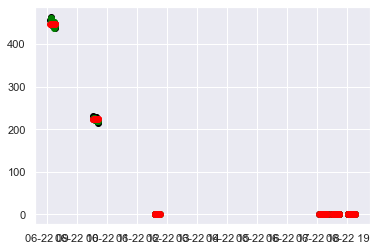

In [35]:
plt.figure()
plt.scatter(time_train, ffnn.predict(X_train_scaled).flatten(), color = 'black', label = 'FFNN_train')
plt.scatter(time_train, y_train, color = 'red', label = 'FFNN')
plt.scatter(time_valid, ffnn.predict(X_valid_scaled).flatten(), color = 'green', label = 'FFNN_valid')
plt.scatter(time_valid, y_valid, color = 'red', label = 'FFNN')

Простая архитектура нейронной сети лучше прогнозирует низкие целевые концентрации по сравнению с моделями MLR.

Так как обучения нн сети процесс стохастический, из-за случайности начальных весов. А нам требуется относительная стабильность предсказаний обучим 11 моделей нейронных сетей. 
Посмотрим метрики для каждой сети на валидации.

Scor0	 train(G2 67%) 	 valid(G2 33%)
R2   	 0.9998 	 0.9998
MSE  	 4.5 	 	 5.1
Scor1	 train(G2 67%) 	 valid(G2 33%)
R2   	 0.9978 	 0.9971
MSE  	 52.1 	 	 80.7
Scor2	 train(G2 67%) 	 valid(G2 33%)
R2   	 0.9994 	 0.9992
MSE  	 13.2 	 	 23.1
Scor3	 train(G2 67%) 	 valid(G2 33%)
R2   	 0.9993 	 0.9992
MSE  	 17.3 	 	 21.1
Scor4	 train(G2 67%) 	 valid(G2 33%)
R2   	 -0.3165 	 -0.3244
MSE  	 30877.5 	 	 36667.1
Scor5	 train(G2 67%) 	 valid(G2 33%)
R2   	 0.9968 	 0.9963
MSE  	 74.2 	 	 101.8
Scor6	 train(G2 67%) 	 valid(G2 33%)
R2   	 0.9969 	 0.9931
MSE  	 73.0 	 	 192.1
Scor7	 train(G2 67%) 	 valid(G2 33%)
R2   	 0.9998 	 0.9998
MSE  	 5.0 	 	 5.0
Scor8	 train(G2 67%) 	 valid(G2 33%)
R2   	 0.9997 	 0.9996
MSE  	 6.9 	 	 10.5
Scor9	 train(G2 67%) 	 valid(G2 33%)
R2   	 -0.2434 	 -0.2562
MSE  	 29163.7 	 	 34779.0
Scor10	 train(G2 67%) 	 valid(G2 33%)
R2   	 -0.2304 	 -0.244
MSE  	 28858.2 	 	 34441.4


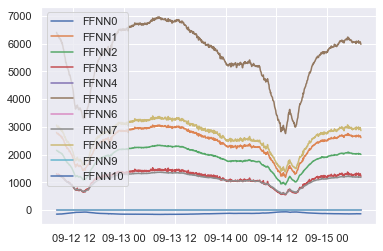

In [38]:
number_model = 11
predict = np.zeros((number_model,len(time_test)))

plt.figure("Test FFNN")
for j in range(number_model):
    ffnn = models.Sequential()

    ffnn.add(layers.Dense(units = 5, activation = 'relu', input_shape=(l_feat,),\
                          kernel_regularizer=regularizers.L1(10**(-4))))
    ffnn.add(layers.Dense(units = 5, activation = 'relu',\
                          kernel_regularizer=regularizers.L1(10**(-4))))
    ffnn.add(layers.Dense(units = 1, activation = 'linear'))
    ffnn.compile(loss = 'mean_absolute_error', optimizer = \
                 keras.optimizers.Adam(learning_rate = 0.01, decay = 0.001),\
                 metrics=['mean_absolute_error','mean_squared_error']) 
    history = ffnn.fit(X_train_scaled, y_train, verbose=0, epochs = 1000,\
                       batch_size = 4, validation_data = (X_valid_scaled,y_valid))
    predict[j] = ffnn.predict(X_test_scaled).flatten()
    
    plt.plot(time_test, predict[j], label = 'FFNN' + str(j))
    
    y_train_pred = ffnn.predict(X_train_scaled).flatten()
    y_valid_pred = ffnn.predict(X_valid_scaled).flatten()
    print('Scor' + str(j) + '\t train(G2 67%) \t valid(G2 33%)')
    print('R2   \t', round(metrics.r2_score(y_train,y_train_pred),4),\
          '\t', round(metrics.r2_score(y_valid,y_valid_pred),4))    
    print('MSE  \t', round(metrics.mean_squared_error(y_train,y_train_pred),1),\
      '\t \t', round(metrics.mean_squared_error(y_valid,y_valid_pred),1))
    keras.backend.clear_session()
plt.legend(loc="best")

По результатам метрик на валидации для 4,9 и 10 моделей (а также 6) проведём отбраковку.
На оставшихся 7 моделях посмотрим медианное значение по прогнозу.
Данное значение будем рассматривать в качестве предсказанного в полевых испытаниях.

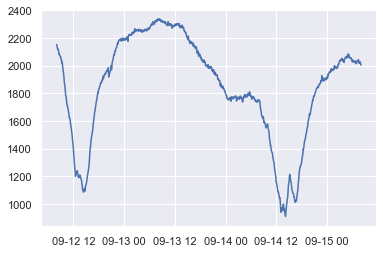

In [47]:
predict_filter = np.delete(predict,[4,6,9,10],axis=0)

predict_median = np.zeros(len(time_test))

for i in range(len(time_test)):
    predict_median = np.median(predict_filter, axis = 0)
plt.plot(time_test, predict_median)


Сравним с обычной MLR. (в Файле MLR рассматриваются также линейные модели с регуляризацией L1,L2)

In [48]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train)
# plotCoefficients(mlr, X_train_scaled, "Coefficients MLR")
print_metrics(mlr)

Scor  	 train(G2 67%) 	 valid(G2 33%)
MAE  	 26.84 	 	 29.13
MSE  	 953.0 	 	 1097.6
R2   	 0.9594 	 0.9604


Как видим результаты на валидации для MLR сильно хуже чем для FFNN.
посмотрим так же результаты прогнозов на тесте.

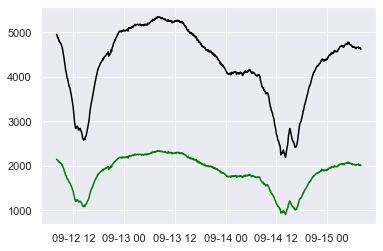

In [51]:
plt.figure("MLR Results")
plt.plot(time_test, mlr.predict(X_test_scaled).flatten(), label = 'MLR', color = 'black')
plt.plot(time_test, predict_median, label = 'FFNN', color = 'green')

Внешний вид схож, посмотрим на коэффициента корреляции пирсона.

In [53]:
print(np.corrcoef(mlr.predict(X_test_scaled).flatten(),predict_median))

[[1.        0.9999452]
 [0.9999452 1.       ]]


Видим линейную зависимость между результатами прогноза для MLR и для FFNN.
Что несколько удивительно. Так как нейронная сеть значительно лучше подгоняет валидационную выборку.
В отличие от MLR, FFNN даёт нелинейное преобразование входных данных. 

Для того чтобы ответить какой прогноз ближе к истине в плане реальных значений SO2
требуется калибровка в полевых испытаниях. 

Стоит исследовать также другие функции активации. Также провести исследование по определению необходимого времени калибровки электрохимического сенсора.  

Как уже отмечалось в файле MLR полевые данные "сильно" другие чем данные с лаборатории.